In [128]:
import numpy as np

In [129]:
class Linear:
    def __init__(self, num_in, num_out, use_bias = True) -> None:
        self.use_bias = use_bias
        self.num_in = num_in
        self.num_out = num_out
        self.matr = (np.random.normal(0, 1., (num_in + (1 if use_bias else 0), num_out)) * 10).clip(np.iinfo(np.int16).min, np.iinfo(np.int16).max).astype(np.int16)
        self.grads = np.zeros_like(self.matr)
        self.last_xs = None

    def get_grad(self, upstream_resp_loss: np.ndarray) -> np.ndarray:
        # divvy up the blame!
        # except now, just do it with the last inputs
        upstream_resp_loss = upstream_resp_loss.clip(np.iinfo(np.int16).min, np.iinfo(np.int16).max).astype(np.int16)

        # the loss 'attributed' that we will pass up, (the loss 'attributed' to inputs) is proportonial to the weight mat
        if not self.use_bias:
            dloss_din = upstream_resp_loss @ self.matr.T
        else:
            # chop off the bias!
            dloss_din = upstream_resp_loss @ self.matr[:-1, :].T

        # the loss 'attributed' to the weights is directly proportional to the inputs we recieved
        dloss_dweights = self.last_xs.T @ upstream_resp_loss

        assert self.grads.shape == dloss_dweights.shape
        self.grads = dloss_dweights.clip(np.iinfo(np.int16).min, np.iinfo(np.int16).max).astype(np.int16)

        return dloss_din

    def forward(self, xs: np.ndarray, no_record: bool = False) -> np.ndarray:
        # fix xs, if we need bias
        fixed_xs = xs
        if self.use_bias:
            fixed_xs = np.hstack((fixed_xs, np.ones((fixed_xs.shape[0], 1))))
        
        if not no_record:
            self.last_xs = fixed_xs
        
        return (fixed_xs @ self.matr).clip(np.iinfo(np.int16).min, np.iinfo(np.int16).max).astype(np.int16)

In [130]:
class LinearPercepFused(Linear):
    def forward(self, xs: np.ndarray, no_record: bool = False) -> np.ndarray:
        outp = super().forward(xs, no_record)
        return np.where(outp > np.uint8(0), np.uint8(1), np.uint8(0))

In [131]:
xs = np.array([[0., 0.], [0., 1.], [1., 0.], [1., 1.]])
# ys = np.array([[0.], [1.], [1.], [0.]])
ys = np.array([[0.], [0.], [1.], [0.]])

xs_repeat = xs.repeat(10, 0)
ys_repeat = ys.repeat(10, 0)
ys_repeat += np.random.normal(0, .1, size=ys_repeat.shape)

In [132]:
ydat_i8 = (ys_repeat*10).clip(np.iinfo(np.int16).min, np.iinfo(np.int16).max).astype(np.int16)
xdat_i8 = (xs_repeat*10).clip(np.iinfo(np.int16).min, np.iinfo(np.int16).max).astype(np.int16)

In [133]:
# ydat_i8

In [134]:
# print(f"{xdat_i8.dtype=}")
# out_l1 = lin1.forward(xdat_i8, True)
# print(f"{out_l1.dtype=}")
# out = lin2.forward(out_l1, True)
# out

In [135]:
# out.dtype

In [136]:
np.array([-128], dtype=np.int16) >> 3

array([-16], dtype=int16)

In [137]:
# print(f"{xdat_i8.dtype=}")
# out_l1 = lin1.forward(xdat_i8, True)
# print(f"{out_l1.dtype=}")
# out = lin2.forward(out_l1, True)
# out

In [138]:
class one_MSE_ish_Loss:
    def __init__(self) -> None:
        self.last_diffs = None

    def get_grad(self) -> np.ndarray:
        return self.last_diffs >> 1

    def forward(self, y: np.ndarray, y_exp) -> np.ndarray:
        self.last_diffs = y - y_exp
        return self.last_diffs * self.last_diffs

In [139]:
lossf = one_MSE_ish_Loss()

In [140]:
from tqdm import tqdm

In [141]:
LR_FAC = 8

lin1 = LinearPercepFused(2, 25, use_bias=True)
lin2 = LinearPercepFused(25, 1, use_bias=True)

losses = []
# for _ in tqdm(range(3000)):
for _ in tqdm(range(3000)):
    example_idx = np.random.randint(0, len(xdat_i8))
    out_l1 = lin1.forward(xdat_i8[example_idx][np.newaxis, :])
    out = lin2.forward(out_l1)

    loss = lossf.forward(out, ydat_i8[example_idx][np.newaxis, :])
    # print(f"{loss=}")
    
    pass_back_grad = lossf.get_grad()
    pass_back_grad = lin2.get_grad(pass_back_grad)
    pass_back_grad = lin1.get_grad(pass_back_grad)
    
    # print(f"{lin1.grads=}")
    # print(f"{lin1.matr=}")

    lin1.matr += lin1.grads >> LR_FAC
    lin2.matr += lin2.grads >> LR_FAC
    losses.append(loss)

100%|██████████| 3000/3000 [00:00<00:00, 5434.09it/s]


In [142]:
import matplotlib.pyplot as plt

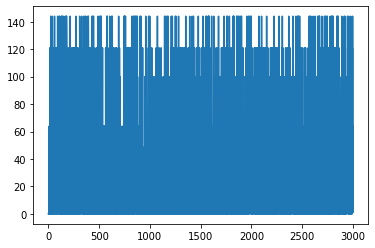

In [143]:
plt.plot(np.array(losses)[:, 0, 0])

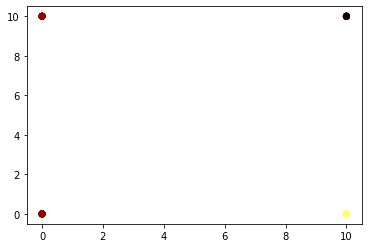

In [144]:
plt.scatter(*list(xdat_i8.T), c=ydat_i8, cmap="hot")

In [145]:
np.arange(-128>>5,128>>5).clip(-128, 128).astype(np.int16)

array([-4, -3, -2, -1,  0,  1,  2,  3], dtype=int16)

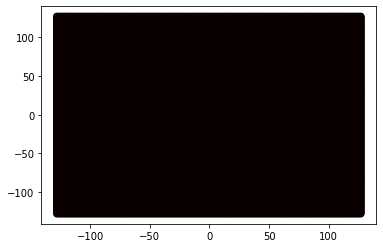

In [146]:
sxs, sys = np.meshgrid(*[np.arange(-128,128).clip(-128, 128).astype(np.int16) for _ in range(2)])
pts = np.vstack([sxs.ravel(), sys.ravel()]).T

out_l1 = lin1.forward(pts, True)
out = lin2.forward(out_l1, True)
out

plt.scatter(pts[:, 0], pts[:, 1], c=out, cmap="hot")

In [147]:
out_l1 = lin1.forward((xs*10).astype(np.int16), True)
out = lin2.forward(out_l1, True)
out

array([[0],
       [0],
       [0],
       [0]], dtype=uint8)